In [1]:
!pip install dfply

In [2]:
!pip install lifetimes

In [3]:
import random
import time, datetime
import os
from functools import reduce
import subprocess
from datetime import datetime, timedelta
from functools import reduce
import pandas as pd
import pathlib
from dfply import *
from lifetimes import BetaGeoFitter
import seaborn as sb
import matplotlib.pyplot as plt
import scipy
import numpy as np
from sklearn.metrics import mean_absolute_error

In [4]:
%matplotlib inline

## training and testing data

In [8]:
path = '/tmp/data/pengcheng/cltv-summary/'

In [9]:
test_start_date = datetime.strptime('2019-01-01', "%Y-%m-%d").date()
test_end_date = datetime.strptime('2019-06-30', "%Y-%m-%d").date()
test_duration = (test_end_date - test_start_date).days/7.0


In [10]:
training_path = os.path.join(path,'17_testing.pkl')
testing_path = os.path.join(path,'17.pkl')

### training data

In [11]:
training_df = pd.read_pickle(training_path)


In [12]:
training_df.describe()

,customer_id,frequency,recency,monetary_value,T
count,4.688552e+07,4.688552e+07,4.688552e+07,4.688552e+07,4.688552e+07
mean,6.460814e+08,7.623310e+00,9.788681e+00,2.654792e+02,1.812018e+01
std,4.155291e+08,4.463335e+01,9.529886e+00,8.245251e+03,7.579343e+00
min,3.840000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.953372e+08,1.000000e+00,0.000000e+00,4.925000e+01,1.257143e+01
50%,5.672284e+08,3.000000e+00,7.428571e+00,1.159091e+02,2.100000e+01
75%,1.115404e+09,9.000000e+00,1.942857e+01,1.914444e+02,2.457143e+01
max,1.193621e+09,2.653700e+05,2.614286e+01,9.999990e+05,2.614286e+01


In [13]:
training_df.head(5)

,customer_id,frequency,recency,monetary_value,T
0,378479488,50,21.142857,95.333336,21.285714
1,307326802,14,24.428571,52.133335,25.857143
2,9167224,4,2.571429,75.400002,9.000000
3,562141206,1,0.428571,109.000000,17.428571
4,319550044,71,25.428571,118.569443,25.857143


In [14]:
len(training_df)

46885522

In [15]:
training_df.recency.quantile([.25, .5, .75, .85, .95, .99])

0.25     0.000000
0.50     7.428571
0.75    19.428571
0.85    22.571429
0.95    24.857143
0.99    25.857143
Name: recency, dtype: float64

In [16]:
training_df.frequency.quantile([.25, .5, .75, .85, .95, .99])

0.25     1.0
0.50     3.0
0.75     9.0
0.85    15.0
0.95    28.0
0.99    55.0
Name: frequency, dtype: float64

In [17]:
training_df >> mask (training_df.frequency > 1000) >> head(2)

,customer_id,frequency,recency,monetary_value,T
1615,322906834,1533,26.000000,132.763367,26.000000
1620,600062715,2820,26.142857,81.887276,26.142857


In [18]:
training_df_filter = training_df[training_df.frequency < training_df.frequency.quantile(.99)]

In [19]:
training_df_filter.frequency.quantile([.25, .5, .75, .85, .95, .99])

0.25     1.0
0.50     3.0
0.75     9.0
0.85    14.0
0.95    26.0
0.99    42.0
Name: frequency, dtype: float64

In [20]:
training_df_filter.monetary_value.quantile([.25, .5, .75, .85, .95, .99])

0.25     49.000000
0.50    116.107140
0.75    192.791672
0.85    256.750000
0.95    399.000000
0.99    559.000000
Name: monetary_value, dtype: float64

### testing data

In [21]:
testing_df = pd.read_pickle(testing_path)


In [22]:
len(testing_df)

58625648

In [23]:
testing_df.head(5)

,customer_id,frequency,recency,monetary_value,T
0,445827048,41,22.285714,135.857147,25.714286
1,531467720,40,22.000000,149.414627,24.000000
2,243358458,9,21.285714,887.099976,22.000000
3,493553170,19,23.857143,197.850006,24.714286
4,328765113,56,24.857143,84.719299,25.000000


In [24]:
testing_df.describe()

,customer_id,frequency,recency,monetary_value,T
count,5.862565e+07,5.862565e+07,5.862565e+07,5.862565e+07,5.862565e+07
mean,6.500210e+08,6.065340e+00,8.125038e+00,2.432452e+02,1.744455e+01
std,3.916018e+08,6.100215e+01,9.014007e+00,8.169390e+03,7.188635e+00
min,4.690000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.096203e+08,0.000000e+00,0.000000e+00,3.500000e+01,1.228571e+01
50%,5.924850e+08,2.000000e+00,4.142857e+00,9.032000e+01,1.942857e+01
75%,1.066422e+09,7.000000e+00,1.642857e+01,1.598294e+02,2.371429e+01
max,1.147579e+09,4.216650e+05,2.571429e+01,9.999990e+05,2.571429e+01


In [25]:
testing_df.frequency.quantile([.25, .5, .75, .85, .95, .99])

0.25     0.0
0.50     2.0
0.75     7.0
0.85    12.0
0.95    24.0
0.99    48.0
Name: frequency, dtype: float64

In [26]:
testing_df_filter = testing_df[testing_df.frequency < testing_df.frequency.quantile(.99)]

In [27]:
testing_df_filter.frequency.quantile([.25, .5, .75, .85, .95, .99])

0.25     0.0
0.50     2.0
0.75     7.0
0.85    11.0
0.95    22.0
0.99    36.0
Name: frequency, dtype: float64

In [28]:
testing_df_filter.monetary_value.quantile([.25, .5, .75, .85, .95, .99])

0.25     35.000000
0.50     89.800003
0.75    160.666672
0.85    214.517242
0.95    399.000000
0.99    499.000000
Name: monetary_value, dtype: float64

### as one

In [29]:
post_df = ( testing_df_filter >> rename(frequency_holdout = X.frequency, id=X.customer_id, money_holdout=X.monetary_value) 
          >> select(X.frequency_holdout, X.id, X.money_holdout))
post_df.head(1)

,frequency_holdout,id,money_holdout
0,41,445827048,135.857147


In [30]:
pre_df = ( training_df_filter >> rename(frequency_cal = 'frequency', recency_cal = 'recency', T_cal='T', id='customer_id') ) 
pre_df.head(1)

,id,frequency_cal,recency_cal,monetary_value,T_cal
0,378479488,50,21.142857,95.333336,21.285714


In [31]:
pre_post_df = pre_df >> left_join(post_df, by='id')

In [32]:
pre_post_df.head(1)

,id,frequency_cal,recency_cal,monetary_value,T_cal,frequency_holdout,money_holdout
0,378479488,50,21.142857,95.333336,21.285714,NaN,NaN


In [33]:
pre_post_df.frequency_holdout.fillna(0.0, inplace=True)

In [34]:
pre_post_df['duration_holdout'] = test_duration

In [35]:
pre_post_df.money_holdout.fillna(0.0, inplace=True)

In [36]:
pre_post_df.head(5)

,id,frequency_cal,recency_cal,monetary_value,T_cal,frequency_holdout,money_holdout,duration_holdout
0,378479488,50,21.142857,95.333336,21.285714,0.0,0.000,25.714286
1,307326802,14,24.428571,52.133335,25.857143,7.0,261.375,25.714286
2,9167224,4,2.571429,75.400002,9.000000,1.0,75.000,25.714286
3,562141206,1,0.428571,109.000000,17.428571,5.0,191.500,25.714286
4,1088024611,49,25.857143,148.440002,26.000000,5.0,97.500,25.714286


In [37]:
#train_testing_df.set_index('id', inplace=True)
#train_testing_df.head(5)

In [38]:
len(pre_post_df)

46397054

## BetaGeo fit

In [39]:
mask=np.random.rand(len(pre_post_df)) <= 0.1

In [40]:
part = pre_post_df[mask]
#part = pre_post_df

In [41]:
part.head(3)

,id,frequency_cal,recency_cal,monetary_value,T_cal,frequency_holdout,money_holdout,duration_holdout
3,562141206,1,0.428571,109.000000,17.428571,5.0,191.500000,25.714286
4,1088024611,49,25.857143,148.440002,26.000000,5.0,97.500000,25.714286
6,219124955,18,19.142857,67.421051,26.142857,19.0,77.650002,25.714286


In [42]:
len(part)

4641812

In [43]:
'''
bgf = BetaGeoFitter(penalizer_coef=0.0001)
bgf.fit(pre_post_df['frequency_cal'], pre_post_df['recency_cal'], pre_post_df['T_cal'], verbose=True, tol=0.4)
bgf
'''

"\nbgf = BetaGeoFitter(penalizer_coef=0.0001)\nbgf.fit(pre_post_df['frequency_cal'], pre_post_df['recency_cal'], pre_post_df['T_cal'], verbose=True, tol=0.4)\nbgf\n"

In [49]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(part['frequency_cal'], part['recency_cal'], part['T_cal'], verbose=True, tol=0.001)
bgf

Optimization terminated successfully.
         Current function value: -11.411703
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14


<lifetimes.BetaGeoFitter: fitted with 4641812 subjects, a: 0.18, alpha: 0.50, b: 1.09, r: 0.43>

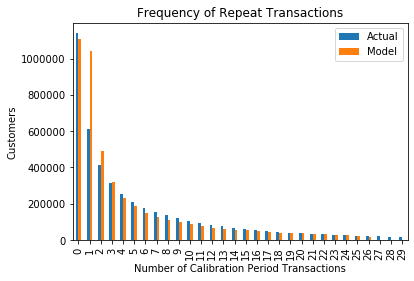

In [50]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf, max_frequency=30)

### model evaluation

In [53]:
t=26
part['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, part['frequency_cal'], part['recency_cal'], part['T_cal'])

part['palive'] = bgf.conditional_probability_alive(part['frequency_cal'], part['recency_cal'], part['T_cal'])

In [54]:
part.sort_values(by='predicted_purchases').head(5)

,id,frequency_cal,recency_cal,monetary_value,T_cal,frequency_holdout,money_holdout,duration_holdout,predicted_purchases,palive
29592158,1060141800,54,0.000000,35.000000,14.571429,0.0,0.000000,25.714286,4.662086e-77,5.513527e-79
4409540,668812027,52,0.000000,34.735847,16.000000,1.0,35.000000,25.714286,3.186506e-76,4.254952e-78
39286564,1009412643,52,0.000000,35.000000,16.000000,0.0,0.000000,25.714286,3.186506e-76,4.254952e-78
26837881,434184076,46,0.000000,103.425529,24.571429,0.0,0.000000,25.714286,8.408158e-76,1.876002e-77
16256894,1053355080,48,0.142857,41.693878,24.571429,22.0,136.130432,25.714286,7.654720e-74,1.637353e-75


In [55]:
part.sort_values(by='predicted_purchases').tail(5)

,id,frequency_cal,recency_cal,monetary_value,T_cal,frequency_holdout,money_holdout,duration_holdout,predicted_purchases,palive
6967445,1192420400,35,0.571429,190.666672,0.571429,0.0,0.0,25.714286,563.615325,0.994842
4703828,1193315757,27,0.142857,16.892857,0.142857,0.0,0.0,25.714286,671.299403,0.993329
36069064,1192728675,30,0.142857,185.000000,0.142857,0.0,0.0,25.714286,745.283692,0.993990
19968663,1192901536,36,0.285714,34.648647,0.285714,0.0,0.0,25.714286,753.916380,0.994984
20843748,1003076911,44,0.000000,49.000000,0.000000,0.0,26.0,25.714286,1348.084527,0.995891


In [56]:
#part.describe()

In [57]:
from sklearn.metrics import mean_squared_error
def perf_trax_freq(df):
    
    def f(row):
        if row['predicted_purchases'] < 0.5:
            val = 0
        elif row['predicted_purchases'] > 25:
            val = 25
        else:
            val = row['predicted_purchases']
        return val

    df['pred'] = df.apply(f, axis=1)
    
    return mean_squared_error(df['frequency_holdout'], df['pred']), df



In [58]:
from sklearn.metrics import mean_squared_error

def perf_trax_freq_by_interval(df, interval, adjusted=False):
    
    def f(row):
        if row['predicted_purchases'] < 0.5:
            val = 0
        elif row['predicted_purchases'] > 45 and adjusted:
            val = 45
        else:
            val = row['predicted_purchases']
        return val
    
    def measure(row, c1, c2):
        if abs(row[c1]-row[c2]) < interval:
            return 1
        else:
            return 0
        
    def alive(row):
        if row['palive'] < 0.3 and row['frequency_holdout'] == 0:
            return 1
        elif row['palive'] >= 0.3 and row['frequency_holdout'] > 0:
            return 1
        else:
            return 0

    df['pred'] = df.apply(f, axis=1)
    df['pred_in'] = df.apply(measure, args=('frequency_holdout', 'pred'), axis=1)
    df['train_in'] = df.apply(measure, args=('frequency_holdout', 'frequency_cal'), axis=1)
    df['alive'] = df.apply(alive, axis=1)
    
    return (mean_squared_error(df['frequency_holdout'], df['pred']), 
            mean_absolute_error(df['frequency_holdout'], df['pred']),
            df['pred_in'].sum()/len(df),
            df['alive'].sum()/len(df),
            mean_squared_error(df['frequency_holdout'], df['frequency_cal']),
            mean_absolute_error(df['frequency_holdout'], df['frequency_cal']),
            df['train_in'].sum()/len(df))

In [59]:
mse, mae, by_interval, alive, mse1, mae1, by_interval1 = perf_trax_freq_by_interval(part, 2, True)

In [60]:
print(mse, mae, by_interval, alive, mse1, mae1, by_interval1)

92.70215663301384 5.726591770111847 0.4221911615550134 0.5541124888297932 72.97278239618494 5.083009609178484 0.37927796300237926


In [61]:
part.frequency_cal.describe()

count    4.641812e+06
mean     6.590400e+00
std      8.980649e+00
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      9.000000e+00
max      5.400000e+01
Name: frequency_cal, dtype: float64

In [62]:
mean_absolute_error(part['frequency_cal'], part['pred'])

2.7394317612905374

In [63]:
mean_absolute_error(part['frequency_cal'], part['predicted_purchases'])

2.864920635460588

In [64]:
part.frequency_holdout.describe()

count    4.641812e+06
mean     5.126149e+00
std      8.103331e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      7.000000e+00
max      4.700000e+01
Name: frequency_holdout, dtype: float64

In [65]:
part.frequency_holdout.quantile([0.75, 0.80, 0.85, 0.9, 0.95, 0.99])

0.75     7.0
0.80     9.0
0.85    12.0
0.90    16.0
0.95    23.0
0.99    37.0
Name: frequency_holdout, dtype: float64

In [66]:
part.predicted_purchases.describe()

count    4.641812e+06
mean     6.598446e+00
std      9.927461e+00
min      4.662086e-77
25%      5.462392e-01
50%      2.431522e+00
75%      8.998102e+00
max      1.348085e+03
Name: predicted_purchases, dtype: float64

In [67]:
part.predicted_purchases.quantile([0.75, 0.80, 0.85, 0.9, 0.95, 0.99])

0.75     8.998102
0.80    11.273895
0.85    14.202280
0.90    18.504342
0.95    26.047768
0.99    42.941773
Name: predicted_purchases, dtype: float64

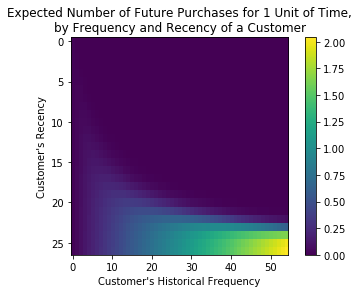

In [68]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

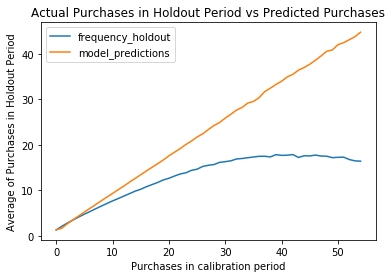

In [69]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
# ax = summary.groupby('frequency_cal')[["frequency_holdout", "model_predictions"]].mean().iloc[:n].plot(**kwargs)
plot_calibration_purchases_vs_holdout_purchases(bgf, part, n=60)

## Gamma Gamma fitting

In [332]:
part.monetary_value.describe()

count    5.800583e+06
mean     2.438799e+02
std      8.162013e+03
min      0.000000e+00
25%      3.500000e+01
50%      8.981818e+01
75%      1.606667e+02
max      9.999990e+05
Name: monetary_value, dtype: float64

In [333]:
part.money_holdout.describe()

count    5.800583e+06
mean     9.029437e+01
std      2.654260e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.160000e+02
max      9.999990e+05
Name: money_holdout, dtype: float64

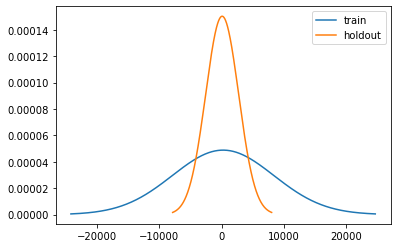

In [351]:
import scipy.stats as stats

mu=244
sigma=8162
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 500)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='train')

ymu=90
ysigma=2654
y = np.linspace(ymu - 3*ysigma, ymu + 3*ysigma, 500)
plt.plot(y, stats.norm.pdf(y, ymu, ysigma), label='holdout')

plt.legend()

In [81]:
#returning_train_df = training_df_filter[training_df_filter.monetary_value > 0]
returning_train_df = part[part.monetary_value > 0]
returning_train_df = returning_train_df[returning_train_df.frequency_cal>0]

In [82]:
returning_train_df.head(2)

,id,frequency_cal,recency_cal,monetary_value,T_cal,frequency_holdout,money_holdout,duration_holdout,predicted_purchases,palive,pred,pred_in,train_in,alive
7,347841373,23,20.428571,172.666672,25.714286,11.0,120.583336,26.142857,7.872922,0.376536,7.872922,0,0,1
8,521845566,12,20.857143,47.615383,23.285714,21.0,90.045456,26.142857,11.437408,0.940307,11.437408,0,0,1


In [83]:
returning_train_df['monetary_value'].describe()

count    3.953848e+06
mean     2.321604e+02
std      6.538715e+03
min      1.000000e+00
25%      4.733333e+01
50%      1.020000e+02
75%      1.732000e+02
max      9.999990e+05
Name: monetary_value, dtype: float64

In [84]:
returning_train_df['frequency_cal'].describe()

count    3.953848e+06
mean     7.572911e+00
std      8.282553e+00
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      1.000000e+01
max      4.700000e+01
Name: frequency_cal, dtype: float64

In [85]:
returning_train_df[['frequency_cal','monetary_value']].corr()

,frequency_cal,monetary_value
frequency_cal,1.000000,-0.007077
monetary_value,-0.007077,1.000000


In [186]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.05)
ggf.fit(returning_train_df['frequency_cal'], returning_train_df['monetary_value'], verbose=True, tol=0.000001)
ggf

Optimization terminated successfully.
         Current function value: 7.023078
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12


<lifetimes.GammaGammaFitter: fitted with 3953848 subjects, p: 1.64, q: 0.29, v: 1.56>

In [187]:
part['avenue'] = ggf.conditional_expected_average_profit(
        part['frequency_cal'],
        part['monetary_value']
    )

In [188]:
part.money_holdout.fillna(0.0, inplace=True)

In [189]:
part.sort_values(by='avenue').tail(4)

,id,frequency_cal,recency_cal,monetary_value,T_cal,frequency_holdout,money_holdout,duration_holdout,predicted_purchases,palive,pred,pred_in,train_in,alive,avenue
13836219,1130223616,1,0.0,982922.0,7.571429,0.0,0.0,26.142857,1.412489,0.375630,1.412489,1,1,0,1.739817e+06
8392046,1089279312,1,0.0,987691.0,17.428571,0.0,0.0,26.142857,0.313556,0.168320,0.000000,1,1,1,1.748259e+06
25508761,1111382469,1,0.0,999366.0,2.428571,1.0,15.0,26.142857,5.752696,0.687089,5.752696,0,1,1,1.768924e+06
19525332,675503439,1,0.0,999999.0,8.571429,0.0,0.0,26.142857,1.156225,0.339643,1.156225,1,1,0,1.770044e+06


In [190]:
part.describe()

,id,frequency_cal,recency_cal,monetary_value,T_cal,frequency_holdout,money_holdout,duration_holdout,predicted_purchases,palive,pred,pred_in,train_in,alive,avenue
count,5.800583e+06,5.800583e+06,5.800583e+06,5.800583e+06,5.800583e+06,5.800583e+06,5.800583e+06,5.800583e+06,5.800583e+06,5.800583e+06,5.800583e+06,5.800583e+06,5.800583e+06,5.800583e+06,5.800583e+06
mean,6.517690e+08,5.161922e+00,7.970081e+00,2.438799e+02,1.737380e+01,4.127174e+00,9.029437e+01,2.614286e+01,5.065317e+00,7.574890e-01,4.977995e+00,5.616810e-01,4.767917e-01,4.797844e-01,2.053256e+02
std,3.919496e+08,7.694515e+00,8.921979e+00,8.162013e+03,7.186198e+00,7.940405e+00,2.654260e+03,2.842171e-14,7.673504e+00,3.330087e-01,7.397101e+00,4.961809e-01,4.994611e-01,4.995912e-01,8.131669e+03
min,4.690000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.614286e+01,3.191756e-56,7.557735e-58,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.576169e+00
25%,3.099887e+08,0.000000e+00,0.000000e+00,3.500000e+01,1.228571e+01,0.000000e+00,0.000000e+00,2.614286e+01,5.961205e-01,6.252257e-01,5.961205e-01,0.000000e+00,0.000000e+00,0.000000e+00,-3.576169e+00
50%,5.940450e+08,2.000000e+00,4.000000e+00,8.981818e+01,1.928571e+01,0.000000e+00,0.000000e+00,2.614286e+01,1.640014e+00,9.370836e-01,1.640014e+00,1.000000e+00,0.000000e+00,0.000000e+00,6.470532e+01
75%,1.066804e+09,7.000000e+00,1.614286e+01,1.606667e+02,2.371429e+01,5.000000e+00,1.160000e+02,2.614286e+01,6.474084e+00,1.000000e+00,6.474084e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.583260e+02
max,1.147577e+09,4.700000e+01,2.571429e+01,9.999990e+05,2.571429e+01,5.400000e+01,9.999990e+05,2.614286e+01,3.984957e+02,1.000000e+00,4.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.770044e+06


In [191]:
np.sqrt(mean_squared_error(part['avenue'], part['money_holdout']))

8531.22980197146

In [192]:
mean_absolute_error(part['avenue'], part['money_holdout'])

200.14716652870538

In [193]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        part['frequency_cal'],
        part['monetary_value']
    ).mean(),
    part[part['frequency_cal']>0]['monetary_value'].mean()
))

Expected conditional average profit: 205.32563582291982, Average profit: 232.15959


In [194]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        part['frequency_cal'],
        part['monetary_value']
    ).mean(),
    part[part['frequency_holdout']>0]['money_holdout'].mean()
))

Expected conditional average profit: 205.32563582291982, Average profit: 182.71432


In [195]:
# refit the BG model to the summary_with_money_value dataset
#bgf.fit(training_df_filter['frequency'], training_df_filter['recency'], training_df_filter['T'])


In [319]:
lifetime_values = ggf.customer_lifetime_value(bgf,
                                              part['frequency_cal'],
                                              part['recency_cal'],
                                              part['T_cal'],
                                              part['monetary_value'],
                                              time = 6,
                                              discount_rate=0.1,
                                              freq='W')

In [320]:
training_money = part >> bind_cols(lifetime_values)


In [321]:
training_money.head(10)

,id,frequency_cal,recency_cal,monetary_value,T_cal,frequency_holdout,money_holdout,duration_holdout,predicted_purchases,palive,pred,pred_in,train_in,alive,avenue,clv
7,347841373,23,20.428571,172.666672,25.714286,11.0,120.583336,26.142857,7.872922,0.376536,7.872922,0,0,1,176.064553,1015.831833
8,521845566,12,20.857143,47.615383,23.285714,21.0,90.045456,26.142857,11.437408,0.940307,11.437408,0,0,1,49.541069,415.335461
9,13488934,12,22.000000,24.538462,24.428571,6.0,32.000000,26.142857,10.998126,0.943671,10.998126,0,0,1,25.596057,206.299413
24,31198150,31,24.285714,101.125000,24.857143,15.0,40.625000,26.142857,28.462755,0.985594,28.462755,0,0,1,102.615249,2140.963575
25,248016572,16,17.714286,198.294113,23.571429,33.0,85.205879,26.142857,7.368225,0.464148,7.368225,0,0,1,203.936407,1101.531502
29,9714012,25,22.857143,181.461533,23.857143,20.0,180.095245,26.142857,23.660701,0.975474,23.660701,0,0,1,184.738525,3204.556206
35,678365729,36,25.000000,78.810814,25.714286,30.0,46.322582,26.142857,31.921226,0.983422,31.921226,1,0,1,79.818598,1867.442885
51,266629534,1,5.000000,442.000000,25.285714,0.0,0.000000,26.142857,0.792583,0.594592,0.792583,1,1,0,785.112943,455.077275
75,555534694,15,23.857143,140.125000,25.571429,7.0,204.750000,26.142857,13.341312,0.962037,13.341312,0,0,1,144.417223,1411.806736
97,515388758,14,5.285714,48.333332,11.857143,0.0,0.000000,26.142857,0.059183,0.002349,0.000000,1,0,1,49.998123,2.177127


In [307]:
def alive(row):
        if row['palive'] >= 0.5:
            return 1
        else:
            return 0

In [322]:
training_money['alive_status'] = training_money.apply(alive, axis=1)


In [326]:
def perf(c1, c2, c3):
    training_money[c1] = training_money[c2]*(training_money[c3]+1)
    training_money['clv_1'] = training_money['clv']*training_money['alive_status']
    training_money.loc[training_money['clv_1'] < 0, 'clv_1'] = 0
    print(np.sqrt(mean_squared_error(training_money['clv_1'], training_money[c1])))
    print(mean_absolute_error(training_money['clv_1'], training_money[c1]))
    
    training_money['clv_2'] = training_money['avenue']*(training_money['pred'])*training_money['alive_status']
    training_money.loc[training_money['clv_2'] < 0, 'clv_2'] = 0

    print(np.sqrt(mean_squared_error(training_money['clv_2'], training_money[c1])))
    print(mean_absolute_error(training_money['clv_2'], training_money[c1]))

In [327]:
perf('money_total_holdout', 'money_holdout', 'frequency_holdout')

39863.75219945865
825.423387451353
48876.92352910333
930.8436522162666


In [328]:
perf('money_total_train', 'monetary_value', 'frequency_cal')

33056.42485000361
778.2936070348553
41508.15587867257
731.3594676345717


In [300]:
np.sqrt(mean_squared_error(training_money['money_total_train'], training_money['money_total_holdout']))

33080.81328272184

In [299]:
mean_absolute_error(training_money['money_total_train'], training_money['money_total_holdout'])

1112.6272012921636

In [306]:
training_money['money_total_train'].describe()

count    5.800583e+06
mean     1.181007e+03
std      2.356017e+04
min      0.000000e+00
25%      7.000000e+01
50%      2.850000e+02
75%      9.960000e+02
max      8.800410e+06
Name: money_total_train, dtype: float64

In [269]:
training_money['money_total_holdout'].describe()

count    5.800583e+06
mean     7.637858e+02
std      2.341080e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.450000e+02
max      5.099995e+07
Name: money_total_holdout, dtype: float64

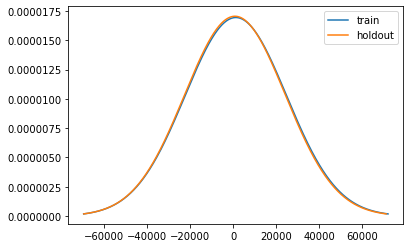

In [353]:
mu=1181
sigma=23560
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 50000)
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='train')

ymu=764
ysigma=23411
y = np.linspace(ymu - 3*ysigma, ymu + 3*ysigma, 50000)
plt.plot(y, stats.norm.pdf(y, ymu, ysigma), label='holdout')

plt.legend()

In [329]:
training_money['clv_1'].describe()

count    5.800583e+06
mean     6.857889e+02
std      3.237179e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.144718e+02
max      3.467951e+07
Name: clv_1, dtype: float64

In [271]:
training_money['clv_2'].describe()

count    5.800583e+06
mean     6.786040e+02
std      1.599868e+04
min     -2.600900e+01
25%      0.000000e+00
50%      0.000000e+00
75%      5.478930e+02
max      1.032960e+07
Name: clv_2, dtype: float64

In [275]:
beg=int(training_money["money_total_holdout"].size*0.6)
beg

3480349

In [256]:
training_money["money_total_holdout"].sort_values().iloc[beg:].describe()

count    2.320234e+06
mean     2.239786e+02
std      3.443378e+02
min      1.200000e+01
25%      3.000000e+01
50%      9.000000e+01
75%      2.400000e+02
max      2.256000e+03
Name: money_total_holdout, dtype: float64

In [257]:
training_money["clv_1"].sort_values().iloc[beg:].describe()

count    2.320234e+06
mean     1.670699e+03
std      2.466458e+04
min      5.027626e+00
25%      2.334490e+02
50%      8.974756e+02
75%      1.929075e+03
max      1.002498e+07
Name: clv_1, dtype: float64

In [258]:
training_money["clv_2"].sort_values().iloc[beg:].describe()

count    2.320234e+06
mean     1.697070e+03
std      2.526193e+04
min     -0.000000e+00
25%      2.366519e+02
50%      9.250178e+02
75%      1.987902e+03
max      1.032960e+07
Name: clv_2, dtype: float64

In [272]:
training_money["money_total_holdout"].quantile([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.50       0.000000
0.60     134.000000
0.70     469.000000
0.80    1084.999962
0.90    2228.999977
0.95    3378.000000
0.99    6070.999817
Name: money_total_holdout, dtype: float64

In [273]:
training_money["clv_1"].quantile([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.50      -0.000000
0.60       5.027652
0.70     233.449318
0.80     897.475625
0.90    1929.074809
0.95    2902.449508
0.99    5254.089678
Name: clv_1, dtype: float64

In [274]:
training_money["clv_2"].quantile([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.50       0.000000
0.60      -0.000000
0.70     236.652242
0.80     925.018002
0.90    1987.902112
0.95    2988.796064
0.99    5370.738252
Name: clv_2, dtype: float64

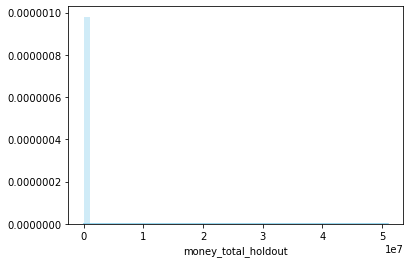

In [276]:

sb.distplot( training_money["money_total_holdout"].sort_values().iloc[beg:] , color="skyblue", label="money_total_holdout")


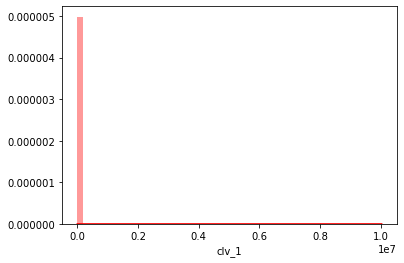

In [277]:
sb.distplot( training_money["clv_1"].sort_values().iloc[beg:] , color="red", label="clv_1")


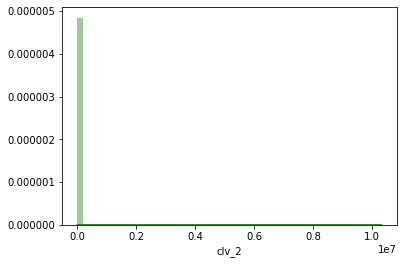

In [278]:
sb.distplot( training_money["clv_2"].sort_values().iloc[beg:], color="green", label="clv_2")

In [104]:
'''
matched = training_money >> left_join(
    testing_df_filter >> select(X.customer_id, X.monetary_value, X.frequency) 
    >> rename(post_monetary_value = X.monetary_value)
    >> rename(post_frequency = X.frequency)
    ,by='id')
matched.clv = matched.clv.fillna(0.0)
'''

"\nmatched = training_money >> left_join(\n    testing_df_filter >> select(X.customer_id, X.monetary_value, X.frequency) \n    >> rename(post_monetary_value = X.monetary_value)\n    >> rename(post_frequency = X.frequency)\n    ,by='id')\nmatched.clv = matched.clv.fillna(0.0)\n"

In [135]:
matched.head(1)

,customer_id,frequency,recency,monetary_value,T,avenue,clv,post_monetary_value,post_frequency
0,1950,1,0.0,10,4.142857,16.52572,1.295969,0.0,NaN


In [136]:
matched['post_monetary_total'] = matched['post_monetary_value']*matched['post_frequency']

In [140]:
matched.post_monetary_total = matched.post_monetary_total.fillna(0.0)

In [141]:
matched >> head(10)

,customer_id,frequency,recency,monetary_value,T,avenue,clv,post_monetary_value,post_frequency,post_monetary_total
0,1950,1,0.000000,10,4.142857,16.525720,1.295969,0.0,NaN,0.0
1,2250,1,0.000000,509,5.714286,637.873543,14.575415,628.0,2.0,1256.0
2,3506,5,6.285714,1045,7.000000,1088.521884,22699.434234,1473.0,8.0,11784.0
3,4590,3,1.428571,29,4.571429,32.204316,30.031110,0.0,NaN,0.0
4,5409,5,3.428571,431,5.428571,449.350398,3959.007996,0.0,NaN,0.0
5,11567,3,0.000000,1344,5.714286,1439.578312,5.349140,49.0,1.0,49.0
6,15432,16,11.285714,2538,11.571429,2569.830605,125646.653907,2905.0,19.0,55195.0
7,17979,1,0.000000,74,6.428571,96.217626,1.365822,0.0,NaN,0.0
8,18730,1,0.000000,149,5.000000,189.606577,7.319847,1031.0,4.0,4124.0
9,23116,4,5.428571,413,5.857143,435.243563,8593.139171,381.0,5.0,1905.0


In [142]:
np.sqrt(mean_squared_error(matched['clv'], matched['post_monetary_total']))

374666.85200750205

In [143]:
mean_absolute_error(matched['clv'], matched['post_monetary_total'])

14256.613970885917

In [149]:
matched['post_monetary_total_training_frequency'] = matched['avenue']*matched['frequency']

In [150]:
np.sqrt(mean_squared_error(matched['post_monetary_total'], matched['post_monetary_total_training_frequency']))

194450.56200957665

In [151]:
mean_absolute_error(matched['post_monetary_total'], matched['post_monetary_total_training_frequency'])

9394.760800414422